In [ ]:
#Set up and Read the data
import pandas as pd
import sqlite3

# read csv file
df_Fact = pd.read_csv('/content/data.csv')

In [ ]:
# connect to database
conn = sqlite3.connect("RFMdb")
cur = conn.cursor()

In [ ]:
# load CRM data into the RFMdb database
df_Fact.to_sql("data", conn)

198911

In [ ]:
# CHECK IF DATA INSERTED INTO data/RFMdb
df_Fact = pd.read_sql('SELECT * FROM data', conn)
df_Fact

,index,ReceiptNo,ProductCode,Description,Quantity,ReceiptDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
198906,198906,554075,22055,MINI CAKE STAND HANGING STRAWBERY,8,5/22/2011 11:29,1.65,16038.0,United Kingdom
198907,198907,554075,37449,CERAMIC CAKE STAND + HANGING CAKES,2,5/22/2011 11:29,9.95,16038.0,United Kingdom
198908,198908,554075,37446,MINI CAKE STAND WITH HANGING CAKES,8,5/22/2011 11:29,1.45,16038.0,United Kingdom
198909,198909,554075,85180B,PINK HEARTS LIGHT CHAIN,3,5/22/2011 11:29,4.65,16038.0,United Kingdom


In [ ]:
# clean data and group transactions by Customerid

cleandata= pd.read_sql(''' SELECT customerid, MAX(receiptdate) AS last_order_date,COUNT(*) AS count_order,SUM(unitprice*quantity) AS totalprice FROM data WHERE receiptno NOT LIKE '%C%' AND customerid IS NOT NULL AND unitprice != 0 GROUP BY customerid ''', conn)

# Write clean CRM data into the database
cleandata.to_sql("cleandata", conn)

2648

In [ ]:
cleandata

,CustomerID,last_order_date,count_order,totalprice
0,12346.0,1/18/2011 10:01,1,77183.60
1,12347.0,12/07/2010 14:57,84,1823.43
2,12348.0,12/16/2010 19:09,28,1487.24
3,12350.0,02/02/2011 16:01,17,334.40
4,12352.0,3/22/2011 16:08,38,1561.81
...,...,...,...,...
2643,18272.0,4/28/2011 18:11,55,980.54
2644,18273.0,3/27/2011 11:22,1,51.00
2645,18280.0,03/07/2011 09:52,10,180.60
2646,18283.0,4/21/2011 16:37,188,435.58


In [ ]:
#clean the data and calculate rfm values
df_Fact = pd.read_sql(''' SELECT customerid, rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 +rfm_frequency*10 + rfm_monetary AS rfm_combined FROM( SELECT customerid,NTILE(4) OVER (ORDER BY last_order_date) AS rfm_recency,NTILE(4) OVER (ORDER BY count_order) AS rfm_frequency,NTILE(4) OVER (ORDER BY totalprice) AS rfm_monetary FROM cleandata)''', conn)

In [ ]:
df_Fact

,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined
0,16282.0,1,1,1,111
1,13253.0,1,2,3,123
2,16532.0,1,1,4,114
3,15266.0,1,1,1,111
4,14653.0,1,3,2,132
...,...,...,...,...,...
2643,13113.0,4,4,4,444
2644,13555.0,4,3,4,434
2645,17007.0,4,2,2,422
2646,13230.0,4,4,4,444


In [ ]:
import matplotlib.pyplot as plt
def rfm_level(df_Fact):
  if ((df_Fact['rfm_recency'] >= 4)
    and (df_Fact['rfm_frequency'] >= 4)
    and (df_Fact['rfm_monetary'] >= 4)):
    return 'Best Customers'
  elif ((df_Fact['rfm_recency'] >= 3)
    and (df_Fact['rfm_frequency'] >= 3)
    and (df_Fact['rfm_monetary'] >= 3)):
    return 'Loyal'
  elif ((df_Fact['rfm_recency'] >= 3)
    and (df_Fact['rfm_frequency'] >= 1)
    and (df_Fact['rfm_monetary'] >= 2)):
    return 'Potential Loyalist'
  elif ((df_Fact['rfm_recency'] >= 3)
    and (df_Fact['rfm_frequency'] >= 1)
    and (df_Fact['rfm_monetary'] >= 1)):
    return 'Promising'
  elif ((df_Fact['rfm_recency'] >= 2)
    and (df_Fact['rfm_frequency'] >= 2)
    and (df_Fact['rfm_monetary'] >= 2)):
    return 'Customers Needing Attention'
  elif ((df_Fact['rfm_recency'] >= 1)
    and (df_Fact['rfm_frequency'] >= 2)
    and (df_Fact['rfm_monetary'] >= 2)):
    return 'At Risk'
  elif ((df_Fact['rfm_recency'] >= 1)
    and (df_Fact['rfm_frequency'] >= 1)
    and (df_Fact['rfm_monetary'] >= 2)):
    return 'Hibernating'
  else:return 'Lost'

In [ ]:
#Create a new variable rfm_level
df_Fact['rfm_level'] = df_Fact.apply(rfm_level, axis=1)
df_Fact

,customerid,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,16282.0,1,1,1,111,Lost
1,13253.0,1,2,3,123,At Risk
2,16532.0,1,1,4,114,Hibernating
3,15266.0,1,1,1,111,Lost
4,14653.0,1,3,2,132,At Risk
...,...,...,...,...,...,...
2643,13113.0,4,4,4,444,Best Customers
2644,13555.0,4,3,4,434,Loyal
2645,17007.0,4,2,2,422,Potential Loyalist
2646,13230.0,4,4,4,444,Best Customers


In [ ]:
# Calculate total customers in each segment
rfm_agg = df_Fact.groupby('rfm_level').agg({'customerid':'count'})
print(rfm_agg)

                             customerid
rfm_level                              
At Risk                             335
Best Customers                      223
Customers Needing Attention         408
Hibernating                         133
Lost                                448
Loyal                               507
Potential Loyalist                  380
Promising                           214


In [ ]:
pip install squarify

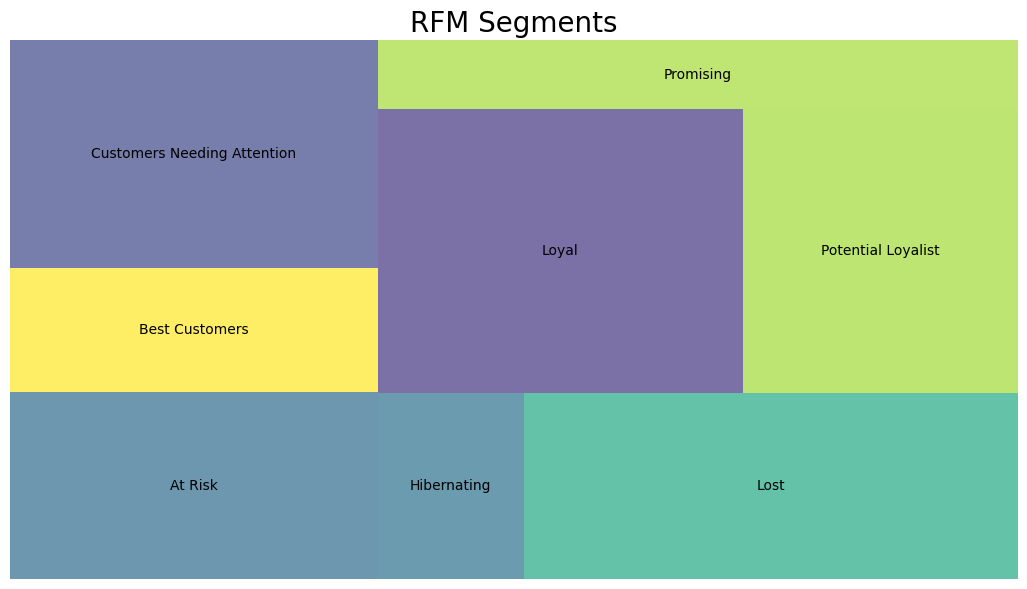

In [ ]:
#RFM visualization, you may have to install squarify
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_agg['customerid'],label=['At Risk','Best Customers','Customers Needing Attention','Hibernating','Lost','Loyal','Potential Loyalist','Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()